In [1]:
import numpy as np

In [2]:
X_train, y_train, X_test, y_test, X_dev, y_dev = np.load('./all_data.npy', allow_pickle = True)

In [3]:
def make_X(x):
    res = []
    x = x[767:]
    for i in range(0, x.shape[0], 768):
#         print(i)
        res.append(np.array(x[i:i+768]))
    print(np.array(res).shape)
    return np.array(res)

In [4]:
X_train, X_test, X_dev = make_X(X_train), make_X(X_test), make_X(X_dev)

(9989, 768)
(2610, 768)
(1109, 768)


In [5]:
from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
X_dev = min_max_scaler.transform(X_dev)

In [6]:
num_classes = 7
time_step = 30

In [7]:
def expand_on_time(X, timestep = time_step):
    tmp = np.reshape(X[0], (1, len(X[0])))
#     print(tmp.shape)
    tmp = np.repeat(tmp, timestep, axis = 0)
#     print(tmp.shape)
    ab = np.reshape(tmp, (1, len(tmp[:,:]), len(tmp[0])))
#     print(ab.shape)
#     print(X.shape)
    X = np.repeat(ab, X.shape[0], axis = 0)
#     print(X.shape)
    return X

In [8]:
# X_train, X_test, X_dev = expand_on_time(X_train), expand_on_time(X_test), expand_on_time(X_dev)

In [9]:
import pandas as pd

loly = pd.DataFrame(y_train, columns = range(0,7))

In [10]:
arr = [4.0, 15.0, 15.0, 3.0, 1.0, 6.0, 3.0]

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import RMSprop, SGD

In [12]:
X_train.shape

(9989, 768)

In [13]:
import tensorflow as tf

with tf.device('/GPU:0'):

    model = Sequential()
#     model.add(LSTM(800, input_shape=(time_step, 768), return_sequences=True))
#     model.add(LSTM(10))
#     model.add(Dropout(0.5))
    # model.add(LSTM(64, return_sequences = True))
#     model.add(Dropout(0.4))
#     model.add(LSTM(150, return_sequences = True))
#     model.add(LSTM(32))
#     model.add(Dropout(0.5))
    # model.add(Activation('softmax'))
    # model.add(Dense(32, activation = 'tanh'))
    # model.add(Dropout(0.4))
    model.add(Input(shape = (768,)))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(num_classes, activation = 'softmax'))

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    #rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 4

In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10)


In [16]:
class_weights = {}

for i in range(7):
    class_weights[i] = arr[i]

In [17]:
class_weights

{0: 4.0, 1: 15.0, 2: 15.0, 3: 3.0, 4: 1.0, 5: 6.0, 6: 3.0}

In [18]:
ist = model.fit(X_train, y_train,
                   validation_data = (X_dev, y_dev), 
#                    validation_set = 0.6,
                   verbose=1, 
                   epochs=500, batch_size=32, 
                   shuffle=True, callbacks=[early_stopping])

Epoch 1/500
313/313 [==============================] - 2s 6ms/step - loss: 1.5423 - accuracy: 0.4743 - val_loss: 1.4142 - val_accuracy: 0.5023
Epoch 2/500
313/313 [==============================] - 2s 6ms/step - loss: 1.3164 - accuracy: 0.5546 - val_loss: 1.4034 - val_accuracy: 0.5293
Epoch 3/500
313/313 [==============================] - 1s 2ms/step - loss: 1.2843 - accuracy: 0.5726 - val_loss: 1.3415 - val_accuracy: 0.5383
Epoch 4/500
313/313 [==============================] - 2s 5ms/step - loss: 1.2399 - accuracy: 0.5895 - val_loss: 1.3305 - val_accuracy: 0.5446
Epoch 5/500
313/313 [==============================] - 1s 5ms/step - loss: 1.2162 - accuracy: 0.5946 - val_loss: 1.3505 - val_accuracy: 0.5410
Epoch 6/500
313/313 [==============================] - 1s 5ms/step - loss: 1.1947 - accuracy: 0.6074 - val_loss: 1.3161 - val_accuracy: 0.5491
Epoch 7/500
313/313 [==============================] - 2s 6ms/step - loss: 1.1895 - accuracy: 0.6107 - val_loss: 1.3138 - val_accuracy: 0.5582

Epoch 58/500
313/313 [==============================] - 2s 6ms/step - loss: 0.5297 - accuracy: 0.8214 - val_loss: 2.5637 - val_accuracy: 0.5419
Epoch 59/500
313/313 [==============================] - 2s 6ms/step - loss: 0.5003 - accuracy: 0.8288 - val_loss: 2.3494 - val_accuracy: 0.5329
Epoch 60/500
313/313 [==============================] - 2s 6ms/step - loss: 0.5099 - accuracy: 0.8200 - val_loss: 2.1860 - val_accuracy: 0.5374
Epoch 61/500
313/313 [==============================] - 0s 1ms/step - loss: 0.5071 - accuracy: 0.8254 - val_loss: 2.2203 - val_accuracy: 0.5239
Epoch 62/500
313/313 [==============================] - 2s 5ms/step - loss: 0.4909 - accuracy: 0.8309 - val_loss: 2.1193 - val_accuracy: 0.5311
Epoch 63/500
313/313 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.8407 - val_loss: 2.2901 - val_accuracy: 0.5374
Epoch 64/500
313/313 [==============================] - 2s 6ms/step - loss: 0.4927 - accuracy: 0.8353 - val_loss: 2.5458 - val_accuracy:

Epoch 115/500
313/313 [==============================] - 1s 4ms/step - loss: 0.3467 - accuracy: 0.8901 - val_loss: 3.1043 - val_accuracy: 0.5176
Epoch 116/500
313/313 [==============================] - 0s 1ms/step - loss: 0.3098 - accuracy: 0.8935 - val_loss: 2.9284 - val_accuracy: 0.5293
Epoch 117/500
313/313 [==============================] - 2s 5ms/step - loss: 0.3422 - accuracy: 0.8895 - val_loss: 2.6685 - val_accuracy: 0.5221
Epoch 118/500
313/313 [==============================] - 0s 1ms/step - loss: 0.3347 - accuracy: 0.8989 - val_loss: 2.9541 - val_accuracy: 0.5176
Epoch 119/500
313/313 [==============================] - 2s 6ms/step - loss: 0.3291 - accuracy: 0.8963 - val_loss: 2.8581 - val_accuracy: 0.5203
Epoch 120/500
313/313 [==============================] - 1s 5ms/step - loss: 0.2858 - accuracy: 0.9061 - val_loss: 3.2894 - val_accuracy: 0.5239
Epoch 121/500
313/313 [==============================] - 1s 4ms/step - loss: 0.3115 - accuracy: 0.8964 - val_loss: 3.0076 - val_ac

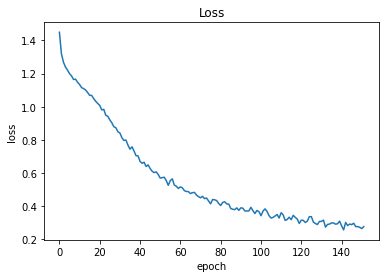

In [21]:
import matplotlib.pyplot as plt

plt.figure()
# plt.subplot(1, 2, 1)
plt.plot(ist.history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.1058566570281982
Test accuracy: 0.553639829158783


In [23]:
def get_tfarray(arr):
    result = []
    for i in arr:
        m = np.max(i)
        result.append(i == m)
    return np.array(result)

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


y_pred = model.predict(X_test)

y_pred = get_tfarray(y_pred)

accuracy_score(y_test, y_pred, normalize=False)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       anger     0.3713    0.2928    0.3274       345
     disgust     0.2632    0.0735    0.1149        68
        fear     0.0816    0.0800    0.0808        50
         joy     0.4477    0.4900    0.4679       402
     neutral     0.7027    0.7508    0.7259      1256
     sadness     0.3023    0.1875    0.2315       208
    surprise     0.4345    0.5552    0.4875       281

   micro avg     0.5536    0.5536    0.5536      2610
   macro avg     0.3719    0.3471    0.3480      2610
weighted avg     0.5355    0.5536    0.5402      2610
 samples avg     0.5536    0.5536    0.5536      2610



In [25]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix


#array([[1, 0, 0],
#   [1, 0, 0],
#   [0, 1, 2]])
cm =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#array([[1.        , 0.        , 0.        ],
#      [1.        , 0.        , 0.        ],
#      [0.        , 0.33333333, 0.66666667]])

#The diagonal entries are the accuracies of each class
cm.diagonal()

array([0.29275362, 0.07352941, 0.08      , 0.49004975, 0.75079618,
       0.1875    , 0.55516014])

In [26]:
predictions = model.predict(X_test)

In [27]:
y_test[0], predictions[0]

(array([0, 0, 0, 0, 0, 0, 1]),
 array([2.4838070e-03, 1.6578076e-04, 4.9461126e-03, 3.6815077e-04,
        9.5068258e-01, 4.0471338e-02, 8.8224153e-04], dtype=float32))

In [28]:
y_test[-1], predictions[-1]

(array([0, 0, 0, 0, 1, 0, 0]),
 array([0.36108568, 0.06568167, 0.04839564, 0.19294956, 0.09595808,
        0.19454487, 0.04138446], dtype=float32))

In [29]:
np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)

(array([6, 0, 4, ..., 4, 4, 4]), array([4, 4, 4, ..., 0, 4, 0]))

In [30]:
pd.DataFrame(np.argmax(predictions, axis = 1)).value_counts()

4    1342
3     440
6     359
0     272
5     129
2      49
1      19
dtype: int64